# Project: AI-Powered Sales Forecasting Dashboard

### Introduction
This notebook documents the end-to-end process of building a sales forecasting model for a retail superstore. Our aim is to analyze historical sales data, uncover trends and seasonality, and create a predictive model that forecasts future sales. The results will feed into an interactive Power BI dashboard to support data-driven decision-making.

We’ll follow a structured workflow: data preparation, exploratory data analysis (EDA), time series modeling, and exporting results for visualization.

### Problem Statement
A retail business must make critical decisions about inventory, marketing, and resource allocation. Without accurate forecasts, these choices often rely on guesswork risking overstock, stockouts, or wasted spend. Our goal is to develop a reliable system to forecast sales, enabling proactive planning and operational optimization.

### Project Objectives
1. **Data Preparation & Cleaning** – Load and preprocess historical sales data; handle missing values and correct data types.
2. **EDA** – Identify trends, seasonality, and drivers of sales such as category and region.
3. **Model Development** – Train a time series forecasting model using Facebook’s Prophet library.
4. **Forecasting & Visualization** – Produce a 12-month forecast and prepare results for BI integration.
5. **Actionable Insights** – Deliver an interactive Power BI dashboard to visualize actuals vs. forecast, filter by dimensions, and inform strategic decisions.


## Data Loading and understanding  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

We load the dataset and print its first 5 rows

In [2]:
df = pd.read_csv('../data/raw/train.csv')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [3]:
#Get a concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [4]:
#checking for null values
df.isnull().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [5]:
df.shape

(9800, 18)

### Data Cleaning and Preprocessing

Our initial df.info() check revealed a few key areas to address:

Correct Data Types: The Order Date and Ship Date columns are currently stored as object (text). For time series forecasting, we shall convert Order Date into a proper datetime format.

Missing Values: The Postal Code column has some missing values. We'll remove the rows with missing data for now. It's a small number of rows and won't significantly impact our overall analysis.

Unnecessary Columns: The Row ID column is a unique identifier for each row and doesn't provide any analytical value. We will drop it to simplify our DataFrame.


In [6]:
#Convert both 'Order Date' and 'Ship Date' to datetime format
df[['Order Date', 'Ship Date']] = df[['Order Date', 'Ship Date']].apply(pd.to_datetime, format='%d/%m/%Y')

In [7]:
df[['Order Date', 'Ship Date']].dtypes

Order Date    datetime64[ns]
Ship Date     datetime64[ns]
dtype: object

In [8]:
# Drop rows with missing values
df.dropna(subset=['Postal Code'], inplace=True)

In [9]:
#drop the Row ID column
df.drop('Row ID', axis=1, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9789 entries, 0 to 9799
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9789 non-null   object        
 1   Order Date     9789 non-null   datetime64[ns]
 2   Ship Date      9789 non-null   datetime64[ns]
 3   Ship Mode      9789 non-null   object        
 4   Customer ID    9789 non-null   object        
 5   Customer Name  9789 non-null   object        
 6   Segment        9789 non-null   object        
 7   Country        9789 non-null   object        
 8   City           9789 non-null   object        
 9   State          9789 non-null   object        
 10  Postal Code    9789 non-null   float64       
 11  Region         9789 non-null   object        
 12  Product ID     9789 non-null   object        
 13  Category       9789 non-null   object        
 14  Sub-Category   9789 non-null   object        
 15  Product Name   9789 n

### Exploratory Data Analysis (EDA)
 
Next we perform EDA to uncover initial insights. The primary goal is to understand the sales trends, seasonality, and overall distribution.

We will start by plotting the total sales over time. This will help us visualize:

- **Trend:** Is the overall sales volume increasing, decreasing, or stable over the years?  
- **Seasonality:** Are there recurring patterns in sales within a year (e.g., spikes during holidays, dips in summer)?  

We set the `Order Date` as the index of our DataFrame, which simplifies plotting and time-based analysis.


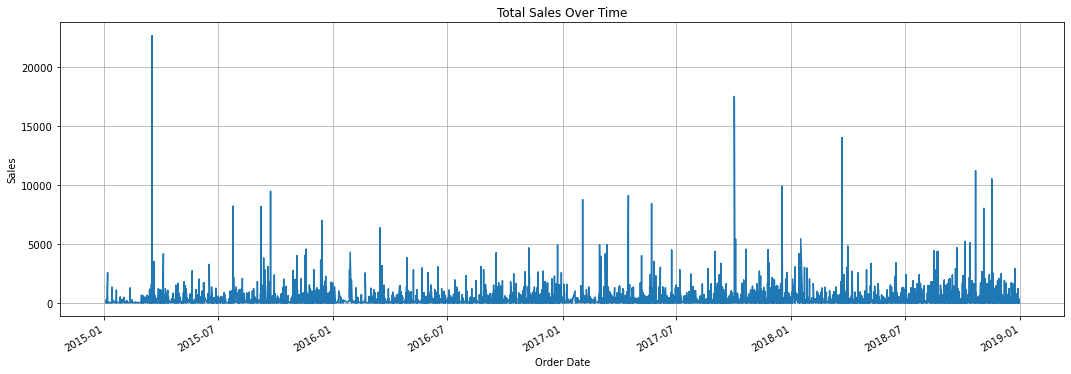

In [11]:
# Set 'Order Date' as the index
df.set_index('Order Date', inplace=True)

# Plotting the sales data
plt.figure(figsize=(18, 6))
df['Sales'].plot()
plt.title('Total Sales Over Time')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


#### Observations:

High Volatility: The plot is extremely "spiky" and volatile. This is because we are plotting every single transaction as a point in time. A day with many small sales and one large sale would look very different, making it difficult to discern a pattern.

Lack of Clear Trend: Due to the noise, it's almost impossible to see if sales are generally increasing or decreasing over time.

No Obvious Seasonality: Similarly, any recurring seasonal patterns are drowned out by the daily transaction noise.

To better visualize the trend and seasonality, we will resample our time series data from a daily to a monthly frequency. We'll aggregate the Sales data by taking the sum for each month.

In [12]:
# Resample to monthly frequency, summing the sales,
monthly_sales = df['Sales'].resample('MS').sum()
monthly_sales.head()

Order Date
2015-01-01    14205.707
2015-02-01     4519.892
2015-03-01    55205.797
2015-04-01    27906.855
2015-05-01    23644.303
Freq: MS, Name: Sales, dtype: float64

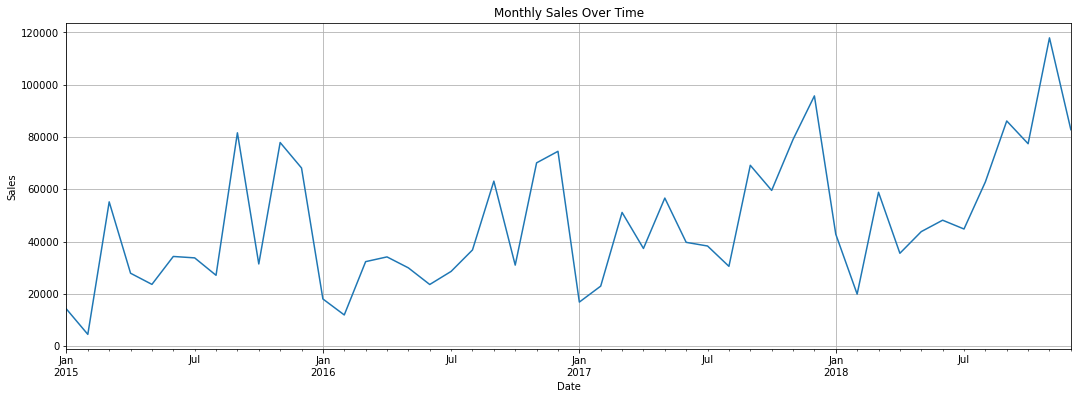

In [13]:
# Plotting the monthly sales data
plt.figure(figsize=(18, 6))
monthly_sales.plot()
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


### Time Series Decomposition

To formally analyze the components of our time series, we can decompose it into three parts:

1. **Trend**: The long-term progression of the series.  
2. **Seasonality**: The repeating short-term cycles in the series.  
3. **Residual**: The random, irregular component left over after removing the trend and seasonality.  

We'll use the `seasonal_decompose` function from the `statsmodels` library to perform this analysis on our monthly sales data.


In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(monthly_sales, model='additive')


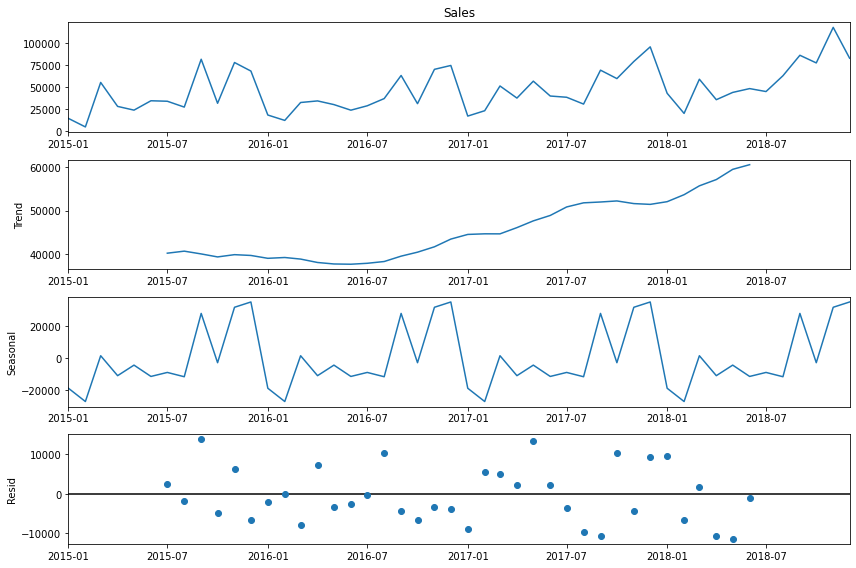

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# Set default figure size
plt.rcParams['figure.figsize'] = (12, 8)

# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(monthly_sales, model='additive')

# Plot decomposition
fig = decomposition.plot()
plt.show()


The decomposition plot confirms our initial observations:

- **Trend**: The trend component shows a consistent, almost linear increase in sales over the four years.  
- **Seasonal**: The seasonal component clearly shows the annual pattern. Sales peak at the end of the year and are lowest around February.  
- **Residual**: The residuals are the leftover noise after removing the trend and seasonality. They appear to be fairly random, which is good, as it suggests our model has captured the main patterns well.  

### Exploring Sales by Category and Region

Beyond time, it's also useful to understand which product categories, regions, or customer segments are driving sales. This can help in targeted marketing and inventory management.We will create bar plots to visualize this.


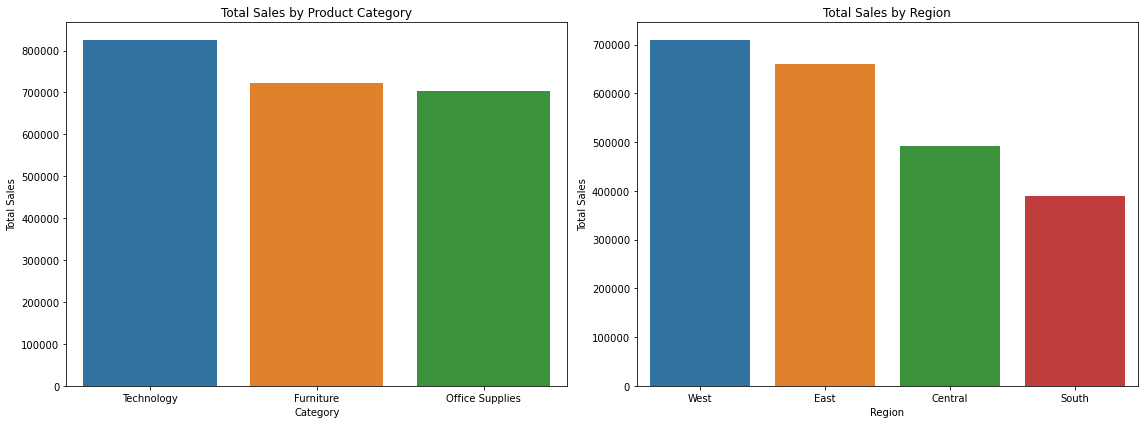

In [16]:
# Group sales by Category and Region
sales_by_category = df.groupby('Category')['Sales'].sum().sort_values(ascending=False)
sales_by_region = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Sales by Category
sns.barplot(x=sales_by_category.index, y=sales_by_category.values, ax=axes[0])
axes[0].set_title('Total Sales by Product Category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Total Sales')

# Plot Sales by Region
sns.barplot(x=sales_by_region.index, y=sales_by_region.values, ax=axes[1])
axes[1].set_title('Total Sales by Region')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Total Sales')

plt.tight_layout()
plt.show()


From these charts, we can see that:

- **Technology** is the highest-grossing category, followed closely by Furniture and then Office Supplies.  
- The **West** and **East** regions are the top contributors to sales, while the South has the lowest sales.  

This kind of information is crucial for business strategy, helping to decide where to focus marketing efforts or which product lines to expand.


## Sales Forecasting with Prophet

We will use Facebook's **Prophet** library, which is powerful and specifically designed for time series forecasting. It's robust to missing data and shifts in the trend, and it typically handles seasonality well.

### Data Preparation for Prophet

Prophet requires the input DataFrame to have a specific format with two columns:  
1. `ds`: The timestamp column (must be datetime).  
2. `y`: The numeric value we want to forecast (in our case, sales).  

We will use our `monthly_sales` data for this.


In [18]:
# Reset index to turn the date index into a column
prophet_df = monthly_sales.reset_index()

# Rename columns to 'ds' and 'y' as required by Prophet
prophet_df.columns = ['ds', 'y']

# Display the first 5 rows of the prepared data
prophet_df.head()


,ds,y
0,2015-01-01,14205.707
1,2015-02-01,4519.892
2,2015-03-01,55205.797
3,2015-04-01,27906.855
4,2015-05-01,23644.303


### Training the Prophet Model

We will set the `yearly_seasonality` to `True` since our EDA clearly showed an annual pattern.


In [19]:
# Initialize the Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

# Fit the model to our data
model.fit(prophet_df)


21:55:28 - cmdstanpy - INFO - Chain [1] start processing
21:55:28 - cmdstanpy - INFO - Chain [1] done processing


### Making Future Predictions

next is to create a DataFrame that extends into the future. We'll ask Prophet to forecast the next 12 months. The `make_future_dataframe` function automatically creates the `ds` column with future dates.


In [20]:
# Create a dataframe for future predictions (12 months)
future = model.make_future_dataframe(periods=12, freq='MS')

# Display the last 5 rows to see the future dates
future.tail()


,ds
55,2019-08-01
56,2019-09-01
57,2019-10-01
58,2019-11-01
59,2019-12-01


In [21]:
# Use the model to make predictions
forecast = model.predict(future)

# Display the forecast for the future periods
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
55,2019-08-01,56166.413282,46730.957044,65774.037993
56,2019-09-01,101892.627658,92861.789388,111169.225796
57,2019-10-01,69094.403996,59678.489291,78935.569541
58,2019-11-01,112815.055933,102984.241641,122070.460392
59,2019-12-01,94243.428195,84972.304248,103373.506737


The `forecast` DataFrame contains the predicted values (`yhat`), along with uncertainty intervals (`yhat_lower` and `yhat_upper`).

### Visualizing the Forecast

Prophet has built-in plotting functions that make it easy to visualize the forecast. We'll use `model.plot()` to see how our forecast compares to the actual historical data.


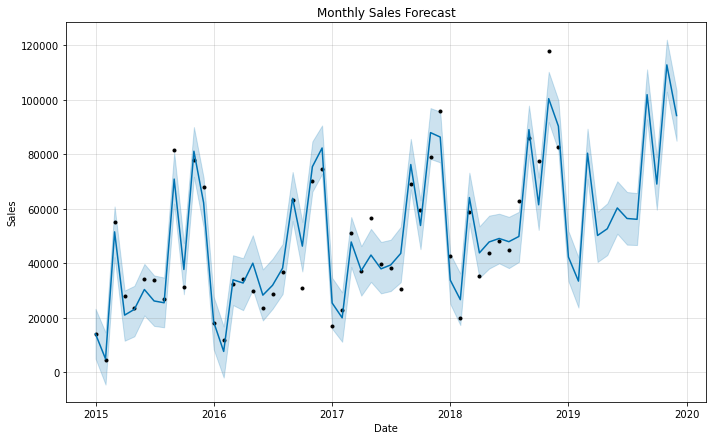

In [22]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.title('Monthly Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


The plot shows:  
- The **black dots** are the actual historical sales data.  
- The **dark blue line (`yhat`)** is our forecast.  
- The **light blue shaded area** represents the uncertainty interval. The model predicts that future sales will likely fall within this range.  

The model has captured the upward trend and the end-of-year seasonal peaks very well.  

### Visualizing Forecast Components

Next we look at the individual components of the forecast to understand what drives the predictions. The `plot_components` function shows the trend and the seasonal patterns the model has learned.


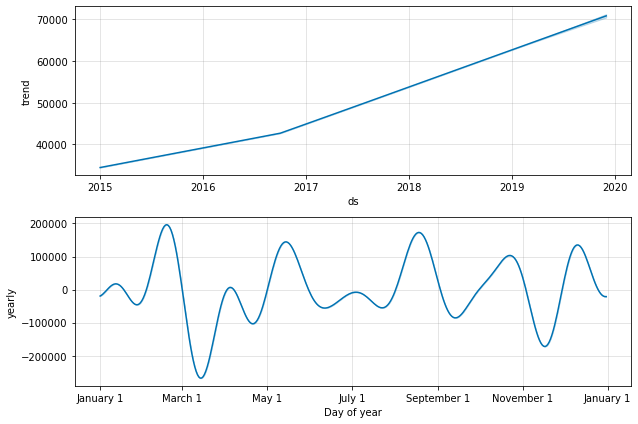

In [23]:
# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()


This plot provides deeper insight:  
- **Trend**: Confirms the steady, positive growth of sales over time.  
- **Yearly Seasonality**: Shows the percentage impact on sales throughout the year. As observed, sales peak in November/December and are lowest in February. This information can be used to plan for inventory, staffing, and marketing campaigns around these key periods.  

### Step 4: Preparing Data for Power BI  

Our final goal is to create an interactive dashboard.We will export our actuals and forecast data into a format that Power BI can easily consume, such as a CSV file.  

We will merge our original DataFrame with the forecast results to have a single file containing historical sales, forecasted sales, and the uncertainty intervals. This will make it straightforward to create comparison visuals in the dashboard.


In [24]:
# Prepare the forecast data for export by selecting relevant columns
forecast_to_export = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Rename 'y' in prophet_df to 'actual_sales' for clarity
prophet_df.rename(columns={'y': 'actual_sales'}, inplace=True)

# Merge historical actual sales with forecast data
final_df = pd.merge(prophet_df, forecast_to_export, on='ds', how='right')

# Save the combined data to a CSV file
final_df.to_csv('../data/processed/sales_forecast_output.csv', index=False)

print("Forecast data has been saved to 'sales_forecast_output.csv'")


Forecast data has been saved to 'sales_forecast_output.csv'


### Conclusion and Next Steps

In this notebook, we have successfully:
1. Loaded and cleaned the historical sales data.
2. Performed exploratory data analysis to uncover trends, seasonality, and key sales drivers like product category and region.
3. Trained a time series forecasting model using Prophet to predict sales for the next 12 months.
4. Exported the results into a clean CSV file, ready for visualization.

**Next Steps:**

The next stage of this project is to take the `sales_forecast_output.csv` file and build an interactive dashboard in **Power BI**. The dashboard should allow users to:
- Visualize historical sales vs. forecasted sales.
- View the uncertainty interval for the forecast.
- Filter the data by other dimensions (e.g., Category, Region, Segment) to gain deeper insights.
- Present key findings and business recommendations based on the analysis.
